## Data story: exploring startup data
****
Goal: to explore and understand available datasets on the subject

Data source: https://www.crunchbase.com/
****

I was curious to learn what data would say about startups, beginning with simple questions, such as which countries have the most startups and what is the percentage of those startups that are still operating vs. those that have already closed. The ultimate research question is whether the choice of an investor, timing of funding, and total funding received have any influence on the company's success (as determined by the company getting acquired or getting listed) or failure (as manifested by the company closing down). I will attempt to visualize this research question in my data story.

The data for the project came from crunchbase, a data company. 

Crunchbase data on startups is broken down into three separate datasets: <b>companies</b> (with specific information on companies), <b>acquisitions</b> (which includes information on acquisitions by startups and of startups), and <b>investments</b> (which focuses on VC funding rounds).

The three datasets used in the project were downloaded on <b>December 4th 2015</b> and were made available on github by a different user. 

Use of this data is governed by the [CrunchBase Terms of Service and Licensing Policy](https://about.crunchbase.com/docs/terms-of-service/). 
****

Let's start by loading different packages that will help us explore all three datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import seaborn as sb

<b>Companies dataset </b>

Next, we will begin by exploring the first dataset, companies.csv. 

In [2]:
companies = pd.DataFrame.from_csv('companies.csv', index_col = None)

In [3]:
companies[0:4]

,permalink,name,homepage_url,category_code,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,last_milestone_at,id
0,/company/8868,8868,http://www.8868.cn,NaN,NaN,operating,NaN,NaN,unknown,NaN,1,NaN,NaN,NaN,NaN,12/1/2013,12/1/2013,NaN,1
1,/company/21e6,2.10E+07,NaN,NaN,5050000.0,operating,USA,CA,SF Bay,San Francisco,1,1/1/2013,2013-01,2013-Q1,2013.0,11/17/2013,11/17/2013,NaN,2
2,/company/club-domains,.Club Domains,http://dotclub.com,software,7000000.0,operating,USA,FL,Fort Lauderdale,Oakland Park,1,10/10/2011,2011-10,2011-Q4,2011.0,5/31/2013,5/31/2013,NaN,3
3,/company/fox-networks,.Fox Networks,http://www.dotfox.com,advertising,4912394.0,closed,ARG,NaN,Buenos Aires,Buenos Aires,1,NaN,NaN,NaN,NaN,1/16/2007,1/16/2007,7/1/2008,4


We can also look at one specific company on the list:

In [4]:
companies.ix[1]

permalink            /company/21e6
name                      2.10E+07
homepage_url                   NaN
category_code                  NaN
funding_total_usd         5.05e+06
status                   operating
country_code                   USA
state_code                      CA
region                      SF Bay
city                 San Francisco
funding_rounds                   1
founded_at                1/1/2013
founded_month             2013-01 
founded_quarter            2013-Q1
founded_year                  2013
first_funding_at        11/17/2013
last_funding_at         11/17/2013
last_milestone_at              NaN
id                               2
Name: 1, dtype: object

Even though it might seem that there is something wrong with the company name, the company's real name is in fact 21e6 -- it's a bitcoin startup. 

Another observation is that several fields for this company have missing information, and we will have to account for that in our future analysis.

Next, let's check the type of all columns in the dataset to make sure we can use them for our analysis going forward.

In [5]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27327 entries, 0 to 27326
Data columns (total 19 columns):
permalink            27327 non-null object
name                 27327 non-null object
homepage_url         25940 non-null object
category_code        26298 non-null object
funding_total_usd    24010 non-null float64
status               27327 non-null object
country_code         25504 non-null object
state_code           16872 non-null object
region               27327 non-null object
city                 24705 non-null object
funding_rounds       27327 non-null int64
founded_at           21441 non-null object
founded_month        21441 non-null object
founded_quarter      21441 non-null object
founded_year         21441 non-null float64
first_funding_at     27176 non-null object
last_funding_at      27176 non-null object
last_milestone_at    14604 non-null object
id                   27327 non-null int64
dtypes: float64(2), int64(2), object(15)
memory usage: 4.0+ MB


Almost all columns are of type object, including those columns containing dates (first_funding_at, last_funding_at, and last_milestone_at). Two columns are of type float (funding_total_usd and founded_year) and one column is of type int (funding_rounds).

Next, let's ask a few questions about the dataset to get to know that data better.

### 1. How many companies are in the dataset and what is the distrubution of companies across the globe?

In [6]:
companies['permalink'].count()

27327

In [7]:
countries = companies.country_code.dropna()
from collections import Counter
countries_dict = Counter(countries)
sorted_countries = sorted(countries_dict.items(), key = lambda x: x[1], reverse = True)
sorted_countries[0:14]

[('USA', 17053),
 ('GBR', 1629),
 ('CAN', 852),
 ('DEU', 622),
 ('FRA', 589),
 ('IND', 505),
 ('ISR', 457),
 ('ESP', 309),
 ('CHN', 299),
 ('SWE', 227),
 ('ITA', 202),
 ('AUS', 201),
 ('IRL', 193),
 ('NLD', 181)]

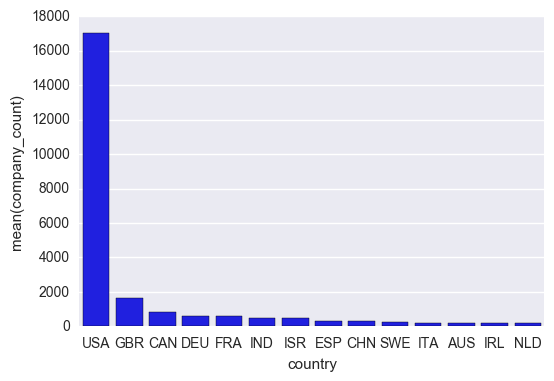

In [8]:
countries_df = pd.DataFrame(sorted_countries[0:14])
countries_df.columns = ['country', 'company_count']

%matplotlib inline

sb.barplot(x ='country', y ='company_count', color = 'blue', data = countries_df)


Looking at the chart, we can already tell that the majority of startups are based in the US, with UK and Canada being distant second and third.

That's one of the basic questions about the data. Now let's look further into questions that are more closely related to our research question, which is centered around success and failure of various startups.

### 2. How many companies are operating, were acquired, got listed, or had to close down.

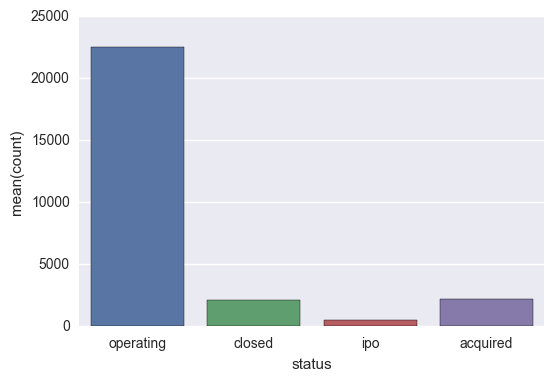

In [9]:
operating = companies[companies.status == 'operating'].permalink.count()
closed = companies[companies.status == 'closed'].permalink.count()
acquired = companies[companies.status == 'acquired'].permalink.count()
ipo = companies[companies.status == 'ipo'].permalink.count()
oper_closed_dict = {'operating': operating, 'closed': closed, 'acquired': acquired, 'ipo': ipo}
oper_closed_df = pd.DataFrame.from_dict(oper_closed_dict, orient = 'index')

oper_closed_df.reset_index(inplace = True)
oper_closed_df.columns = ['status', 'count']

sb.barplot(data = oper_closed_df, x = 'status', y='count')

Here are the more precise numbers:

In [10]:
oper_closed_df

,status,count
0,operating,22523
1,closed,2153
2,ipo,475
3,acquired,2176


Based on the data, we can see that less than 10% of companies are identified as closed in the database, while a similar number of startups have already been acquired.

It is those closed (unsuccessful) vs. acquired or listed (successful) companies that we will be particularly interested in later in our analysis.

Visualizing total funding and status (operating or closed) would also be interesting to see the full picture.

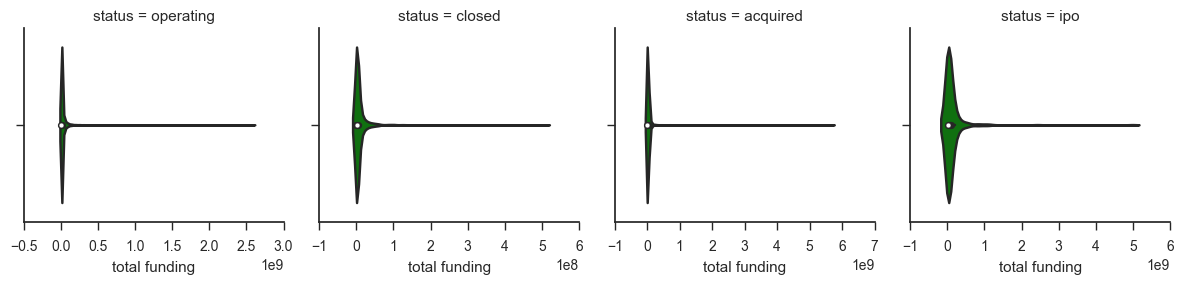

In [11]:
total_funding = companies['funding_total_usd']
status = companies['status']
funding_vs_status = {'total funding': total_funding, 'status': status}
fund_vs_status_df = pd.DataFrame(funding_vs_status)

sb.set(style="ticks", color_codes=True)
g = sb.FacetGrid(fund_vs_status_df, col="status", sharex = False)
g = g.map(sb.violinplot, "total funding", color = "green")

What is interesting here is that while companies that closed have similar funding size distribution patterns compared to other companies, those that were acquired or got listed are notable for extreme outlier cases. We can have a look at some of those.

In [12]:
large_funding = companies['funding_total_usd'] > 100000000
companies[large_funding]["status"].value_counts()

operating    392
ipo          103
acquired      52
closed        14
Name: status, dtype: int64

These numbers show that for the subset of startups that received total funding over $100m, most companies ended up being listed (18.4%), with only 14 (2.5%) closing down. For comparison purposes, the proportion of closed companies in the entire dataset is 7.9% compared to 1.7% listed companies.

### Dealing with duplicates

One of the big problems when dealing with human-generated data is human error. The existence of duplicates is one such area that one has to account for when working with company datasets. To ensure that our dataset doesn't have any duplicates, we will rely on the fuzzywuzzy package, which uses Levenshtein Distance to spot potential duplicates.

In [13]:
from fuzzywuzzy import fuzz

C:\Users\Lana\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [14]:
company_name_list = companies.name

Let's check if any of the company names are duplicates.

In [15]:
company_name_list.duplicated().value_counts()

False    27326
True         1
Name: name, dtype: int64

Based on this, it seems that there is one company name that is a duplicate. Let's find out which one.

In [16]:
company_name_list[company_name_list.duplicated()]

16777    OneMln
Name: name, dtype: object

And here the lines which have the duplicate. Clearly, this is the same company, and all of the data for it is the same.

In [17]:
companies[companies.name == 'OneMln']

,permalink,name,homepage_url,category_code,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,last_milestone_at,id
16776,/company/onemln,OneMln,http://www.smarttm.co,software,NaN,operating,POL,NaN,Torun,Torun,1,1/1/2012,2012-01,2012-Q1,2012.0,1/1/2013,1/1/2013,1/1/2012,16777
16777,/company/onemln,OneMln,http://www.smarttm.co,software,NaN,operating,POL,NaN,Torun,Torun,1,1/1/2012,2012-01,2012-Q1,2012.0,1/1/2013,1/1/2013,1/1/2012,16778


Let's delete this row and check for duplicates again

In [18]:
companies = companies[companies.id != 16777]
companies['permalink'].count()

27326

In [19]:
companies[companies.name == 'OneMln']

,permalink,name,homepage_url,category_code,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,last_milestone_at,id
16777,/company/onemln,OneMln,http://www.smarttm.co,software,NaN,operating,POL,NaN,Torun,Torun,1,1/1/2012,2012-01,2012-Q1,2012.0,1/1/2013,1/1/2013,1/1/2012,16778


Whereas company duplicates that match 100% might be easy to spot, it becomes harder if there are typos in company names. At this point we will employ fuzzywuzzy partial_ratio function to spot and map out potential duplicates.

In [20]:
len(companies)

27326

In [21]:
companies = companies.reset_index()

In [22]:
companies[companies.name == 'OneMln']

,index,permalink,name,homepage_url,category_code,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,last_milestone_at,id
16776,16777,/company/onemln,OneMln,http://www.smarttm.co,software,NaN,operating,POL,NaN,Torun,Torun,1,1/1/2012,2012-01,2012-Q1,2012.0,1/1/2013,1/1/2013,1/1/2012,16778


In [ ]:
def duplicate_cleanup(some_list):
    company_name_list =[]
    other_companies = []
    ratio =[]
    count = 0
    next_count = 0
    length = len(some_list)
    for count in range (count, length):
        count_entry = some_list[count]
        next_count = count + 1
        for next_count in range(next_count, length):
            next_count_entry = some_list[next_count]
            company_name_list.append(count_entry)
            other_companies.append(next_count_entry)
            ratio_companies = fuzz.partial_ratio(count_entry, next_count_entry)
            ratio.append(ratio_companies)
    final_dict = {'company names 1': company_name_list, 
                  'company names 2': other_companies,
                  'ratio': ratio}
    df = pd.DataFrame(final_dict)
    return df

In [ ]:
ratio_names = duplicate_cleanup(companies.name)
ratio_names